# Improved geodesic integration with automatic differentiation

The idea is to integrate the geodesic equation as a series of 40 coupled second-order differential equations, using:

$$
\frac{d}{dt} \begin{bmatrix} \dot x^\mu \\ \ddot x^\mu \end{bmatrix}
= \begin{bmatrix} { {\dot x}^\mu \\ -{\Gamma^\mu}_{\alpha \beta} {\dot x}^\alpha {\dot x}^\beta } \end{bmatrix}
$$

Which is derived from:

$$
\ddot x^\mu + {\Gamma^\mu}_{\alpha \beta} {\dot x}^\alpha {\dot x}^\beta = 0
$$

Thus, the only thing required to properly integrate the geodesics is knowing the Christoffel symbols beforehand for the metric. Here is an example for the Schwarzschild metric:

$$
\Gamma_{\mu\nu}^0=
\begin{pmatrix}
0&\frac{1}{2}\frac{r_s}{r^2-rr_s}&0&0\\
\frac{1}{2}\frac{r_s}{r^2-rr_s}&0&0&0\\
0&0&0&0\\
0&0&0&0
\end{pmatrix}
$$

$$
\Gamma_{mu}^1=\begin{pmatrix}
\frac{1}{2}\left(\frac{r_s}{r^2}-\frac{r_s^2}{r^3}\right)&0&0&0\\
0&\frac{1}{2}\frac{r_s}{rr_s-r^2}&0&0\\
0&0&r_s-r&0\\
0&0&0&\left(r_s-\right) \sin^2 \theta
\end{pmatrix}
$$

$$
\Gamma_{\mu \nu}^2=\begin{pmatrix}
0&0&0&0\\
0&0&\frac{1}{r}&0\\
0&\frac{1}{r}&0&0\\
0&0&0&-\sin\theta \cos \theta
\end{pmatrix}
$$

$$
\Gamma_{\mu \nu}^3=\begin{pmatrix}
0&0&0&0\\
0&0&0&\frac{1}{r}\\
0&0&0&\cot\theta\\
0&\frac{1}{r}&\cot \theta&0
\end{pmatrix}
$$

In [393]:
import numpy as np
from scipy.integrate import solve_ivp, odeint
import matplotlib.pyplot as plt
from tqdm import tqdm

To perform the numerical integration, a custom Runge-Kutta 4th order solver was used:

In [394]:
def rk4(f, u0, t0, tf, n):
    """
    Expects a function in the form y' = f(y, t) to solve
    f - function, MUST return numpy array of derivatives
    u0 - initial values
    t0 - initial time
    tf - final time
    n - number of samples
    """
    t = np.linspace(t0, tf, n+1)
    u = np.array((n+1)*[u0])
    h = t[1]-t[0]
    for i in tqdm(range(n)):
        k1 = h * f(u[i], t[i])    
        k2 = h * f(u[i] + 0.5 * k1, t[i] + 0.5*h)
        k3 = h * f(u[i] + 0.5 * k2, t[i] + 0.5*h)
        k4 = h * f(u[i] + k3, t[i] + h)
        u[i+1] = u[i] + (k1 + 2*(k2 + k3 ) + k4) / 6
    return u, t

In [112]:
# HUGE thanks to https://github.com/OrangeStanley/Geodesic-lines/blob/main/Geodesic_v2.ipynb
def sch_d_dt(X, t, M=1):
    # Array of derivatives
    f = np.zeros(X.shape)
    x = X[:4]
    velocities = X[4:]
    f[:4] = velocities
    t, r, theta, phi = x
    # Holder for Christoffel symbols
    Gamma = np.zeros((4,4,4))
    Gamma[0,0,1] = M / r**2 * (1 - 2 * M / r)
    Gamma[0,1,0] = M / (
        r**2 * (1 - 2 * M / r)
    )
    Gamma[1,1,1] = -M / (
        r**2 * (1 - 2 * M / r)
    )
    Gamma[1,2,2] = 1 / r
    Gamma[1,3,3] = 1 / r
    Gamma[2,2,1] = - r * (
        1 - 2 * M / r
    )
    Gamma[3,3,1] = - r * ( 
        1 - 2 * M / r
    ) * np.sin(theta) ** 2
    Gamma[2,3,3] = np.cos(theta) / np.sin(theta)
    Gamma[3,3,2] = -np.sin(theta) * np.cos(theta)
    for i in range(4):
        Gamma[:,:,i] = Gamma[:,:,i] + np.transpose(Gamma[:,:,i])
        Gamma[:,:,i] = Gamma[:,:,i] - np.diag(np.diag(Gamma[:,:,i]))/2
        # return derivatives
        f[4 + i] = -velocities @ Gamma[:,:,i] @ velocities
    return f

In [107]:
x_initial = np.array([
    0, 10, np.pi/2, 0 # t, r, theta, phi
])
v_initial = np.array([
    1, 0, 0, 0.03 # dt/dt, dr/dt, dtheta/dt, dphi/dt
])
xv_initial = np.concatenate((
    x_initial, v_initial
))

In [108]:
tf = 1500
samples = 5000
geodesic = rk4(sch_d_dt, xv_initial, 0, tf, samples)

In [109]:
t = geodesic[1]
x_sol = geodesic[0][:,:4] # disregard velocity components

In [110]:
tau = x_sol[:,0]
r = x_sol[:,1]
theta = x_sol[:,2]
phi = x_sol[:,3]

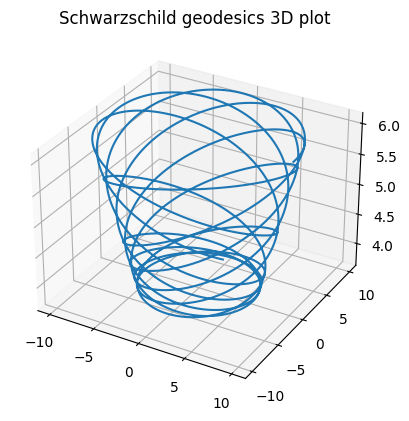

In [111]:
fig = plt.figure()
ax = plt.axes(projection="3d")

x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

ax.plot3D(x, y, z)
ax.set_title("Schwarzschild geodesics 3D plot")
plt.show()

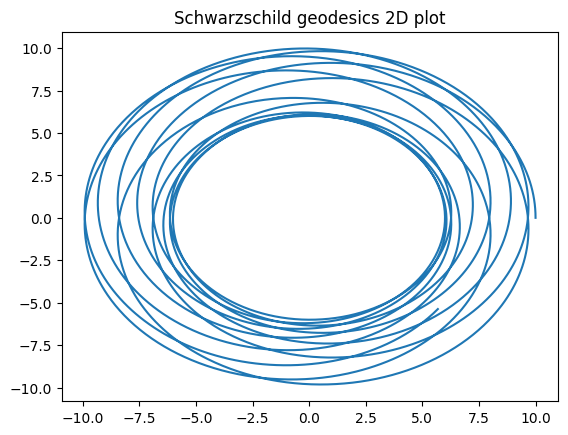

In [97]:
fig = plt.figure()
ax = plt.axes()

x = r * np.cos(phi)
y = r * np.sin(phi)

ax.plot(x, y)
ax.set_title("Schwarzschild geodesics 2D plot")
plt.show()

We can perform a similar geodesic integration for the Kerr metric: we simply need to calculate the geodesics beforehand from the metric. As a reminder, the Kerr metric is given by:

$$
ds^2 = -\left(1 - \frac{2 M r}{\Sigma}\right) dt^2 + \frac{\Sigma}{\Delta} dr^2 + \Sigma d\theta^2 + \left(r^2 + a^2 + \frac{2 M r a^2}{\Sigma} \sin^2 \theta \right) \sin^2 \theta d\phi^2 - \frac{2 M r a sin^2 \theta}{\Sigma} dt d\phi
$$

Where the metric coefficients are given by [[2]](https://math.uchicago.edu/~may/REU2017/REUPapers/Hoang.pdf):

$$
g_{\mu\nu} = \pmatrix{
	-(1 - \frac{2 M r}{\Sigma}) & 0 & 0 & -\frac{2 M r a \sin^2 \theta}{\Sigma} \\
	0 & \frac{\Sigma}{\Delta} & 0 & 0 \\
	0 & 0 & \Sigma & 0 \\
	-\frac{2 M r a \sin^2 \theta}{\Sigma} & 0 & 0 & \left(r^2 + a^2 + \frac{2 M r a^2}{\Sigma} \sin^2 \theta \right) \sin^2 \theta
}
$$

And $\Sigma$ and $\Delta$ are respectively given by:

$$
\Sigma = r^2 + a^2 \cos^2 \theta
$$

$$
\Delta = r^2 - 2 M r + a^2
$$

With EinsteinPy we can trivially calculate the Christoffel symbols as follows:

In [114]:
from einsteinpy.symbolic import MetricTensor, ChristoffelSymbols
import sympy
sympy.init_printing()

In [115]:
coords = sympy.symbols("t r theta phi")
coords

In [116]:
M, sigma, delta, a = sympy.symbols("M Sigma Delta a")

In [126]:
metric4x4 = [[0 for i in range(4)] for i in range(4)]
metric4x4[0][0] = -(1 - (2 * M * coords[1]) / sigma)
metric4x4[0][3] = -(2 * M * coords[1] * a * sympy.sin(coords[2]) ** 2) / sigma
metric4x4[1][1] = sigma / delta
metric4x4[2][2] = sigma
metric4x4[3][0] = -(2 * M * coords[1] * a * sympy.sin(coords[2]) ** 2) / sigma
metric4x4[3][3] = (coords[1] ** 2 + a ** 2 + (2 * M * coords[1] * a ** 2) / sigma * (sympy.sin(coords[2]) ** 2)) * sympy.sin(coords[2]) ** 2

In [127]:
kerr_metric = MetricTensor(metric4x4, coords)
kerr_metric.tensor()

⎡                                              2              ⎤
⎢    2⋅M⋅r                         -2⋅M⋅a⋅r⋅sin (θ)           ⎥
⎢    ───── - 1      0  0           ─────────────────          ⎥
⎢      Σ                                   Σ                  ⎥
⎢                                                             ⎥
⎢                   Σ                                         ⎥
⎢        0          ─  0                   0                  ⎥
⎢                   Δ                                         ⎥
⎢                                                             ⎥
⎢        0          0  Σ                   0                  ⎥
⎢                                                             ⎥
⎢            2            ⎛     2      2             ⎞        ⎥
⎢-2⋅M⋅a⋅r⋅sin (θ)         ⎜2⋅M⋅a ⋅r⋅sin (θ)    2    2⎟    2   ⎥
⎢─────────────────  0  0  ⎜──────────────── + a  + r ⎟⋅sin (θ)⎥
⎣        Σ                ⎝       Σ                  ⎠        ⎦

In [130]:
ch_syms = ChristoffelSymbols.from_metric(kerr_metric)

In [133]:
ch0 = sympy.simplify(ch_syms.tensor()[0])
ch0

⎡                                                                     ⎛ 2    2⎞                
⎢                                                                   M⋅⎝a  + r ⎠                
⎢                         0                           ───────────────────────────────────────  
⎢                                                          2      2           3      2      2  
⎢                                                     2⋅M⋅a ⋅r⋅cos (θ) + 2⋅M⋅r  - Σ⋅a  - Σ⋅r   
⎢                                                                                              
⎢                      ⎛ 2    2⎞                                                               
⎢                    M⋅⎝a  + r ⎠                                                               
⎢      ───────────────────────────────────────                           0                     
⎢           2      2           3      2      2                                                 
⎢      2⋅M⋅a ⋅r⋅cos (θ) + 2⋅M⋅r  - Σ⋅a  

In [134]:
ch1 = sympy.simplify(ch_syms.tensor()[1])
ch1

⎡                                       2             ⎤
⎢    -Δ⋅M                      Δ⋅M⋅a⋅sin (θ)          ⎥
⎢    ─────      0  0           ─────────────          ⎥
⎢       2                             2               ⎥
⎢      Σ                             Σ                ⎥
⎢                                                     ⎥
⎢      0        0  0                 0                ⎥
⎢                                                     ⎥
⎢      0        0  0                 0                ⎥
⎢                                                     ⎥
⎢         2              ⎛   2    4             2   ⎞ ⎥
⎢Δ⋅M⋅a⋅sin (θ)        -Δ⋅⎝M⋅a ⋅sin (θ) + Σ⋅r⋅sin (θ)⎠ ⎥
⎢─────────────  0  0  ────────────────────────────────⎥
⎢       2                             2               ⎥
⎣      Σ                             Σ                ⎦

In [135]:
ch2 = sympy.simplify(ch_syms.tensor()[2])
ch2

⎡                                       M⋅a⋅r⋅sin(2⋅θ)                 ⎤
⎢      0         0  0                   ──────────────                 ⎥
⎢                                              2                       ⎥
⎢                                             Σ                        ⎥
⎢                                                                      ⎥
⎢      0         0  0                         0                        ⎥
⎢                                                                      ⎥
⎢      0         0  0                         0                        ⎥
⎢                                                                      ⎥
⎢                       ⎛     2      2         2      2⎞               ⎥
⎢M⋅a⋅r⋅sin(2⋅θ)        -⎝4⋅M⋅a ⋅r⋅sin (θ) + Σ⋅a  + Σ⋅r ⎠⋅sin(θ)⋅cos(θ) ⎥
⎢──────────────  0  0  ────────────────────────────────────────────────⎥
⎢       2                                      2                       ⎥
⎣      Σ                                      Σ    

In [136]:
ch3 = sympy.simplify(ch_syms.tensor()[3])
ch3

⎡                                                                        M⋅a                   
⎢                         0                            ─────────────────────────────────────── 
⎢                                                           2      2           3      2      2 
⎢                                                      2⋅M⋅a ⋅r⋅cos (θ) + 2⋅M⋅r  - Σ⋅a  - Σ⋅r  
⎢                                                                                              
⎢                                                                                              
⎢                        M⋅a                                                                   
⎢      ───────────────────────────────────────                            0                    
⎢           2      2           3      2      2                                                 
⎢      2⋅M⋅a ⋅r⋅cos (θ) + 2⋅M⋅r  - Σ⋅a  - Σ⋅r                                                  
⎢                                       

Notice, however, that there is clearly one issue: the Christoffel symbols tend to be extraordinarily complex, especially when manually typeset into the equation giving the derivatives. Thus, the next step will be to calculate the Christoffel symbols automatically via automatic differentiation, so this is no longer an issue.

As a basic example, consider the Euclidean spherical metric in spherical coordinates:

$$
ds^2 = dr^2 + r^2 d\theta^2 + r^2 \sin^2 d\phi^2
$$

Here, we calculate the values of the Christoffel symbols for the spherical metric in 3D Euclidean space analytically:

In [233]:
coords = sympy.symbols("r theta phi")
matrix = [[0 for i in range(3)] for i in range(3)]
matrix[0][0] = 1
matrix[1][1] = coords[0] ** 2
matrix[2][2] = coords[0] ** 2 * sympy.sin(coords[1]) ** 2
m = MetricTensor(matrix, coords)

In [234]:
m.tensor()

⎡1  0       0     ⎤
⎢                 ⎥
⎢    2            ⎥
⎢0  r       0     ⎥
⎢                 ⎥
⎢        2    2   ⎥
⎣0  0   r ⋅sin (θ)⎦

In [238]:
ch = ChristoffelSymbols.from_metric(m)
ch.tensor()

⎡                                             ⎡             1   ⎤⎤
⎢                     ⎡   1                ⎤  ⎢0    0       ─   ⎥⎥
⎢⎡0  0       0     ⎤  ⎢0  ─        0       ⎥  ⎢             r   ⎥⎥
⎢⎢                 ⎥  ⎢   r                ⎥  ⎢                 ⎥⎥
⎢⎢0  -r      0     ⎥  ⎢                    ⎥  ⎢           cos(θ)⎥⎥
⎢⎢                 ⎥  ⎢1                   ⎥  ⎢0    0     ──────⎥⎥
⎢⎢             2   ⎥  ⎢─  0        0       ⎥  ⎢           sin(θ)⎥⎥
⎢⎣0  0   -r⋅sin (θ)⎦  ⎢r                   ⎥  ⎢                 ⎥⎥
⎢                     ⎢                    ⎥  ⎢1  cos(θ)        ⎥⎥
⎢                     ⎣0  0  -sin(θ)⋅cos(θ)⎦  ⎢─  ──────    0   ⎥⎥
⎣                                             ⎣r  sin(θ)        ⎦⎦

And now, with the assistance of automatic differentiation, numerically at $(r, \theta, \phi) = (3, \pi / 2, 0.1)$:

In [332]:
import torch
import torch.autograd.functional as functional

In [333]:
# initial coordinates
r0, theta0, phi0 = (3., torch.pi/2, 0.1)
coord = torch.tensor([r0, theta0, phi0], requires_grad=True)
print("r, theta, phi coordinates: ",coord.data)

r, theta, phi coordinates:  tensor([3.0000, 1.5708, 0.1000])


In [338]:
jacob = torch.autograd.functional.jacobian(metric_tensor, coord, create_graph=True)
jacob

tensor([[[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]],

        [[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]])

In [341]:
def metric_tensor(coords):
    r = coords[0]
    theta = coords[1]
    phi = coords[2]
    return torch.tensor([
        [1., 0., 0.],
        [0., r ** 2, 0.],
        [0., 0., r ** 2 * torch.sin(theta) ** 2]
    ], requires_grad=True)

def inverse_metric(coords):
    metric = metric_tensor(coords)
    return torch.inverse(metric)

In [384]:
def calculate_christoffel(jacob, g_inv, dims):
    # based on https://github.com/AndreaAntoniali/Riemann-tensor-calculator/blob/main/Riemann_Calculations.ipynb
    gamma = np.zeros((dims, dims, dims))
    for beta in range(dims):
        for mu in range(dims):
            for nu in range(dims):
                for alpha in range(dims):
                    gamma[beta,mu,nu] = 1/2 * g_inv[alpha][beta] * (jacob[alpha][mu][nu] + jacob[alpha][nu][mu] - jacob[mu][nu][alpha])
    return gamma

def christoffel_at_point_4d(metric, inverse_metric=inverse_metric, t, r, theta, phi, dims):
    coord = torch.tensor([t, r, theta, phi], requires_grad=True)
    g_inv = inverse_metric(coord)
    jacobian = torch.autograd.functional.jacobian(metric, coord, create_graph=True)
    return calculate_christoffel(jacobian, g_inv, dims)

In [385]:
def kerr_metric(coords, M=1, a=0.97):
    t = coords[0]
    r = coords[1]
    theta = coords[2]
    phi = coords[3]
    sigma = r ** 2 + a ** 2 * torch.cos(theta) ** 2
    delta = r ** 2 - 2 * M * r + a ** 2
    return torch.tensor([
        [-(1 - (2 * M * r) /sigma), 0., 0., -((2 * M * r * a * torch.sin(theta) ** 2) / sigma)],
        [0., sigma / delta, 0., 0.],
        [0., 0., sigma, 0.],
        [-((2 * M * r * a * torch.sin(theta) ** 2) / sigma), 0., 0., (r ** 2 + a ** 2 + (2 * M * r * a ** 2)/sigma * torch.sin(theta) ** 2) * torch.sin(theta) ** 2]
    ])

def kerr_inverse_metric(coords, M=1, a=0.97):
    # Based off https://www.roma1.infn.it/teongrav/onde19_20/kerr.pdf
    t = coords[0]
    r = coords[1]
    theta = coords[2]
    phi = coords[3]
    sigma = r ** 2 + a ** 2 * torch.cos(theta) ** 2
    delta = r ** 2 - 2 * M * r + a ** 2
    return torch.tensor([
        [-1 / delta * (r ** 2 + a ** 2 + (2 * M * r * a ** 2) / sigma * torch.sin(theta) ** 2), 0., 0., -(2 * M * r * a) / (sigma * delta)],
        [0., delta / sigma, 0., 0.],
        [0., 0., 1 / sigma, 0.],
        [-(2 * M * r * a) / (sigma * delta), 0., 0., (delta - a ** 2 * torch.sin(theta) ** 2) / (sigma * delta * torch.sin(theta) ** 2)]
    ])

def kerr_d_dt(X, t):
    # Array of derivatives
    f = np.zeros(X.shape)
    x = X[:4]
    velocities = X[4:]
    f[:4] = velocities
    t, r, theta, phi = x
    Gamma = christoffel_at_point_4d(kerr_metric, kerr_inverse_metric, t, r, theta, phi, 4)

    for i in range(4):
        Gamma[:,:,i] += np.transpose(Gamma[:,:,i])
        Gamma[:,:,i] -= np.diag(np.diag(Gamma[:,:,i]))/2
        f[4 + i] = -velocities @ Gamma[:,:,i] @ velocities
    return f

In [395]:
kerr_x_initial = np.array([
    0, 10, np.pi/2, 0 # t, r, theta, phi
])
kerr_v_initial = np.array([
    1, 0, 0, 0.03 # dt/dt, dr/dt, dtheta/dt, dphi/dt
])
kerr_xv_initial = np.concatenate((
    x_initial, v_initial
))

In [396]:
tf = 1500
samples = 5000
kerr_geodesic = rk4(kerr_d_dt, kerr_xv_initial, 0, tf, samples)

100%|████████████████████████████████████████████████████████| 5000/5000 [04:39<00:00, 17.90it/s]


In [397]:
t = kerr_geodesic[1]
x_sol = kerr_geodesic[0][:,:4] # disregard velocity components

In [398]:
tau = x_sol[:,0]
r = x_sol[:,1]
theta = x_sol[:,2]
phi = x_sol[:,3]

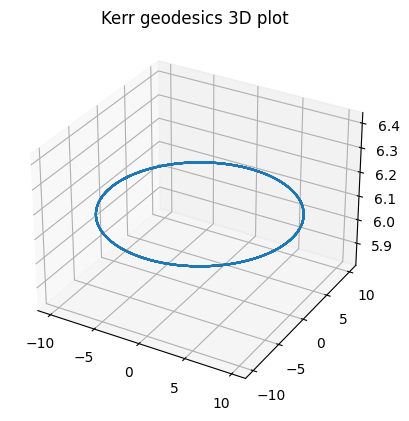

In [399]:
fig = plt.figure()
ax = plt.axes(projection="3d")

x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)
z = r * np.cos(theta)

ax.plot3D(x, y, z)
ax.set_title("Kerr geodesics 3D plot")
plt.show()

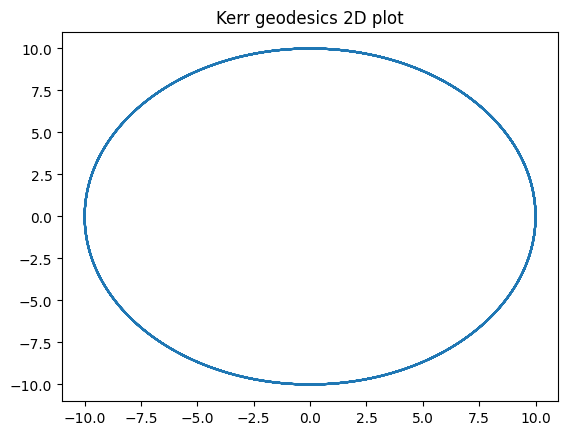

In [400]:
fig = plt.figure()
ax = plt.axes()

x = r * np.cos(phi)
y = r * np.sin(phi)

ax.plot(x, y)
ax.set_title("Kerr geodesics 2D plot")
plt.show()